# What is driving Zestimate Errors?
**Author: Cayt Schlichting**<br>
*Audience: Zillow Data Science Team*

**Project Goal:**  The goal of this project is to attempt to identify trends in Zestimate errors on single unit properties.  By identifying the situations in which our home value estimates are more inaccurate, we could potential identify errors in our underlying model.  Improving the performance of our Zestimate model has positive business outcomes in the form of product dominance and an increase in customer base and satisfaction.

**Initial Hypotheses -** Logerror will be:
- Worse at the lowest and highest home values
- Influenced by geography
- Mildly correlated with transaction month


**Jump to Section:** &ensp;   [Acquisition and Prep](#acq-prep) - [Exploration](#explore) - [Modeling](#modeling) - [Conclusion](#ConclusionC88)

In [1]:
#Basics
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

#Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind') #set theme for all viz

#modeling and stats
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

#my modules
import utils
import wrangle_zillow as wz

***
## Data Acquisition and Preparation  <a class="anchor" id="acq-prep">
***

**Source:**&ensp; Data is from the Zillow SQL database on the Codeup server.  A data dictionary can be found [here](https://github.com/Cayt-Schlichting/zillow-clustering-project#data-dictionary).

**Pre-Filtering:**
> - Only **'single unit'** properties with transactions in 2017 were used in this analysis:
>   - Properties with unitcnts > 1 were dropped (nulls in this column were kept
>   - Properites with the following property land use types were kept:
>     - Single Family (261), PUD (269), Mobile home (263), Townhouse (264), Condominium (266), Manufactured, etc (275), Residential general (260), Rural residence (262), Bungalow (273), Zero Lot Line (274), Inferred Single Family (279), Patio Home (276) <br>
> - Columns with 2% or more **nulls** were dropped from the dataset, then any remaining indices with nulls were removed.  This allowed me to keep the bulk of the data and columns, without imputing.

**Cleaning Summary:**
> - **Dropped columns:**
>   - duplicates: propertylandusetypeid, finishedsquarefeet12, calculatedbathnbr, regionidcounty
>   - target-related: structuretaxvaluedollarcnt, landtaxvaluedollarcnt, tax amount
>   - geographic: regionidcity, regionidzip, rawcensustractandblock, censustractandblock
> - **Converted to INT:** bedroomcnt, yearbuilt, fullbathcnt, latitude and longitude, roomcnt, calculatedfinishedsquarefeet
> - Only the month of transaction data was kept
> - Fips was mapped to county name for readability
> - County and propertylandusetype were encoded
> - Columns were renamed for readability and coding simplicity
    
**Outlier-Filtering:** 
> An IQR outlier filtering operation was performed on the following columns: 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'logerror'
    

##### Acquire, Prep and Split data

In [2]:
#Acquisition and Prep - using 70/15/15 split 
tr, te, val = wz.wrangle_zillow(val_ratio=.15,test_ratio=.15)

In [3]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40525 entries, 14720402 to 12082600
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   logerror                                    40525 non-null  float64
 1   bath                                        40525 non-null  float64
 2   bed                                         40525 non-null  int64  
 3   sf                                          40525 non-null  int64  
 4   fullbathcnt                                 40525 non-null  int64  
 5   lat                                         40525 non-null  int64  
 6   lon                                         40525 non-null  int64  
 7   roomcnt                                     40525 non-null  int64  
 8   yearbuilt                                   40525 non-null  int64  
 9   value                                       40525 non-null  float64
 10  

***
## Exploration  <a class="anchor" id="explore" />
***
*More exploration can be found in the supporting notebooks*


##### Target variable distribution

In [4]:
#subset explore dataframe and reorder columns
eda_cols = ['value','logerror','bed','bath','fullbathcnt','roomcnt',\
            'sf','yearbuilt','trans_month','landusedesc','county','lat','lon']
tr_eda = tr[eda_cols]

<AxesSubplot:xlabel='logerror', ylabel='Count'>

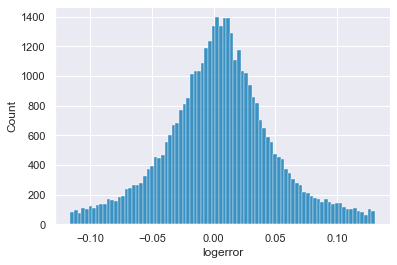

In [5]:
sns.histplot(data=tr_eda, x='logerror')

### Clustering
Exploration was done with and without clustering.  Here I recreate the chosen clusters.

##### Create model inputs

In [6]:
#break out model input columns
X_cols = ['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt','yearbuilt', 'trans_month',\
  'Orange', 'Ventura','Manufactured, Modular, Prefabricated Homes', 'Mobile Home',\
  'Planned Unit Development', 'Residential General','Single Family Residential', 'Townhouse']

X_tr = tr[X_cols]
X_te = te[X_cols]
X_val = val[X_cols]

In [7]:
#Create base scaled subsets
scale_cols = ['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt','yearbuilt', 'trans_month']
X_tr_scaled, X_te_scaled, X_val_scaled = utils.scale_X(X_tr,X_te,X_val,columns=scale_cols,kind='minmax')

In [8]:
#Break out clustering combinations
#Create simple inputs for my clusters
simp_cols = ['bed', 'sf', 'Orange','Ventura']
X_tr_simp_scaled = X_tr_scaled[simp_cols]
#Try with only room inputs
room_cols = ['bath','bed','roomcnt']
X_tr_room_scaled = X_tr_scaled[room_cols]
#Try with primary rooms and sf
roomSF_cols = ['bath','bed','sf']
X_tr_roomSF_scaled = X_tr_scaled[roomSF_cols]

##### Look at inertia for each set of model inputs

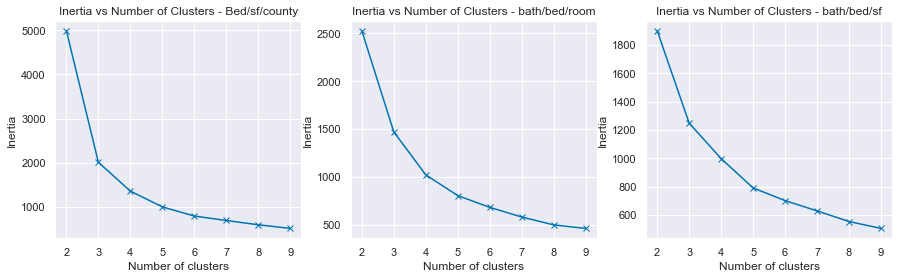

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(131)
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_simp_scaled).inertia_ for k in range(2, 10)}).plot(marker='x')
    plt.xticks(range(2, 10))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters - Bed/sf/county')
plt.subplot(132)
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_room_scaled).inertia_ for k in range(2, 10)}).plot(marker='x')
    plt.xticks(range(2, 10))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters - bath/bed/room')
plt.subplot(133)
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_roomSF_scaled).inertia_ for k in range(2, 10)}).plot(marker='x')
    plt.xticks(range(2, 10))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters - bath/bed/sf')

**NOTES:** Based off the changes in inertia, I will use the following cluster numbers: 3,4,3 - respectively

##### Create cluster models and store each set as a new feature

In [10]:
#Simple
model_simp = KMeans(4).fit(X_tr_simp_scaled) #create and fit
X_tr_simp_scaled['cluster'] = model_simp.predict(X_tr_simp_scaled) #predict
tr['cluster_simp'] = X_tr_simp_scaled['cluster'].copy()

#Rooms only
model_room = KMeans(4).fit(X_tr_room_scaled) #create and fit
X_tr_room_scaled['cluster'] = model_room.predict(X_tr_room_scaled) #predict
tr['cluster_room'] = X_tr_room_scaled['cluster'].copy()

#Rooms + SF
model_roomSF = KMeans(3).fit(X_tr_roomSF_scaled) #create and fit
X_tr_roomSF_scaled['cluster'] = model_roomSF.predict(X_tr_roomSF_scaled) #predict
tr['cluster_roomSF'] = X_tr_roomSF_scaled['cluster'].copy()

##### Visualize the clusters

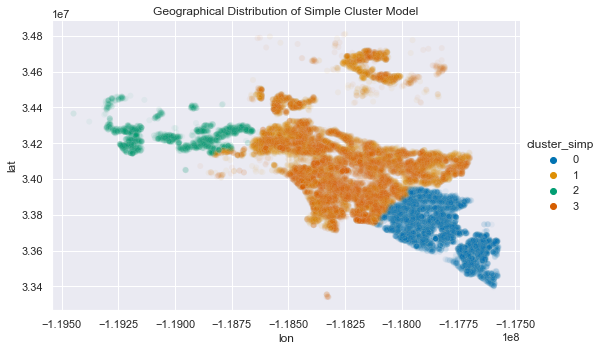

In [11]:
sns.relplot(data=tr,x='lon',y='lat',hue='cluster_simp',palette='colorblind',alpha=.05,aspect=1.5)
plt.title('Geographical Distribution of Simple Cluster Model');

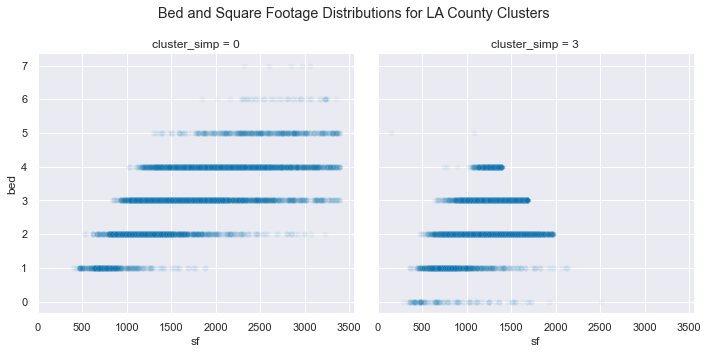

In [12]:
g=sns.relplot(data=tr[(tr.cluster_simp.isin([0,3]))],x='sf',y='bed',col='cluster_simp',col_wrap=2,palette='colorblind',alpha=.05);
g.fig.suptitle('Bed and Square Footage Distributions for LA County Clusters');
g.tight_layout()

**Notes:** The simple cluster model broke the clusters up by county (one cluster is Ventura, another is Orange), Then it split LA into two clusters.  Looking at the LA clusters, we see that it was split into a high square footage and high bedroom group, and a low square footage and low bedroom group

In [13]:
#rename those groups:
tr.cluster_simp = tr.cluster_simp.map({0:'LA_general',1:'Orange',2:'Ventura',3:'LA_expensive'})

Looking at the room clusters

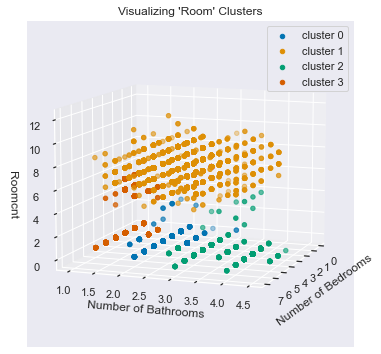

In [14]:
#PLOTTING    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in tr.groupby('cluster_room'):
    ax.scatter(subset['bed'],subset['bath'],subset['roomcnt'],label='cluster ' + str(grp))
ax.legend() #pretty up the graph
ax.set(xlabel='Number of Bedrooms', ylabel='Number of Bathrooms', zlabel='Roomcnt',title="Visualizing 'Room' Clusters");
#good viewing angle
ax.view_init(10,20)

Look at the Bath/Bed/SF clusters

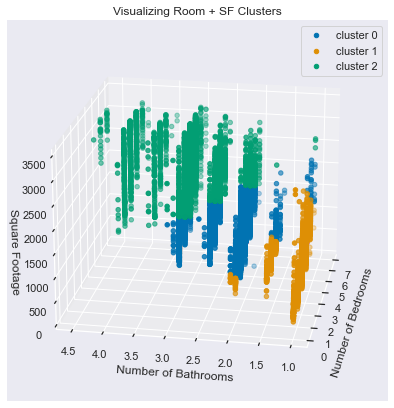

In [15]:
#PLOTTING    
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in tr.groupby('cluster_roomSF'):
    ax.scatter(subset['bed'],subset['bath'],subset['sf'],label='cluster ' + str(grp))
ax.legend() #pretty up the graph
ax.set(xlabel='Number of Bedrooms', ylabel='Number of Bathrooms', zlabel='Square Footage',title='Visualizing Room + SF Clusters');
ax.view_init(20,190) #good viewing angle

**Notes:** These clusters are broken about into 1) Big houses with many bath and bedrooms  2) medium houses with 2-3 baths, or 1 bath, many bedrooms and 3) Houses with <2 bath, low-to-mid number of bathrooms

In [16]:
#rename those groups:
tr.cluster_roomSF = tr.cluster_roomSF.map({0:'<2 baths',1:'Mid SF, mid baths',2:'High SF, many rooms'})

### Does logerror vary by clusters?

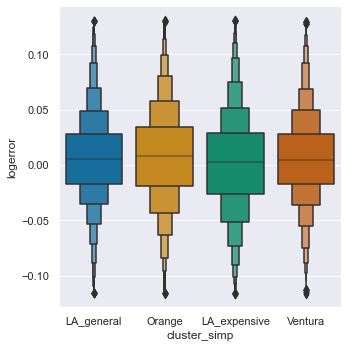

In [17]:
#
sns.catplot(data=tr,x='cluster_simp',y='logerror',kind='boxen')

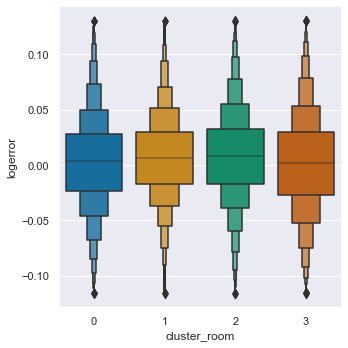

In [18]:
sns.catplot(data=tr,x='cluster_room',y='logerror',kind='boxen')

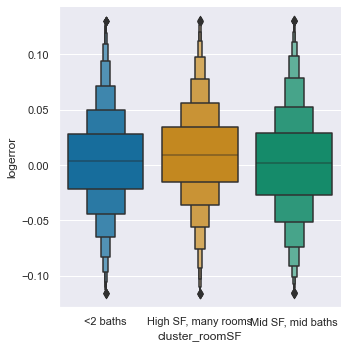

In [19]:
sns.catplot(data=tr,x='cluster_roomSF',y='logerror',kind='boxen')

<div class="alert alert-success"><b>Cluster Summary:</b>  All 3 cluster models seemed to have slightly different median logerrors.  I am not confident in the roomcnt feature and would likely not use that cluster set moving forward.  Time permitting, I could use the other clusters to create separate models.</div>

### Is Logerror correlated with home value?

### Is Logerror correlated with home value?

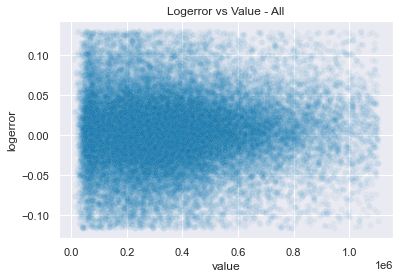

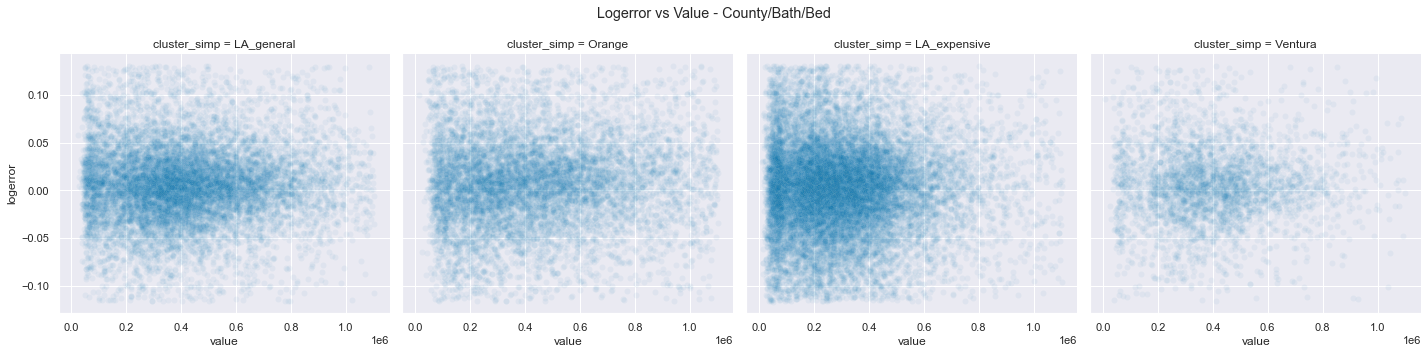

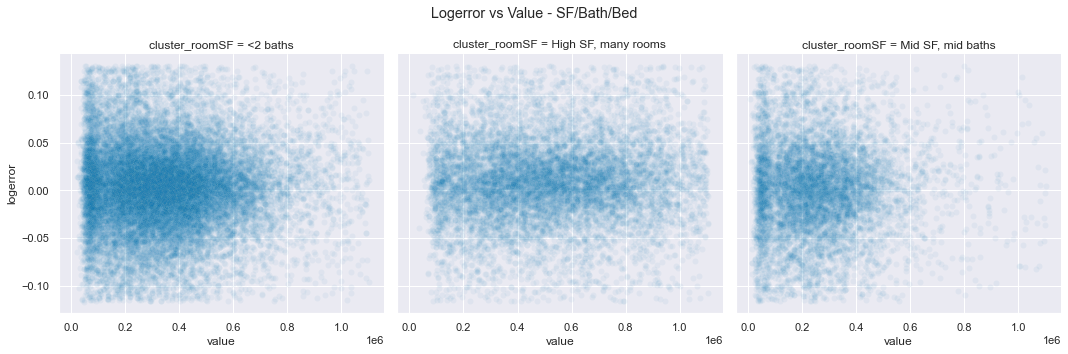

In [20]:
display(Markdown('### Is Logerror correlated with home value?'))
#Do Visualizations
sns.scatterplot(data=tr,x='value',y='logerror',alpha=.05);
plt.title('Logerror vs Value - All')
plt.show()
g=sns.relplot(data=tr,x='value',y='logerror',col='cluster_simp',alpha=.05)
g.fig.suptitle('Logerror vs Value - County/Bath/Bed')
plt.tight_layout()
g =sns.relplot(data=tr,x='value',y='logerror',col='cluster_roomSF',alpha=.05)
g.fig.suptitle('Logerror vs Value - SF/Bath/Bed')
plt.tight_layout()

<div class="alert alert-success"><b>Notes:</b> The above graphs show no obvious relationships between logerror and value, even when broken out by clusters.</div>

### Does Logerror change with geography?

### Is Logerror correlated with geography?

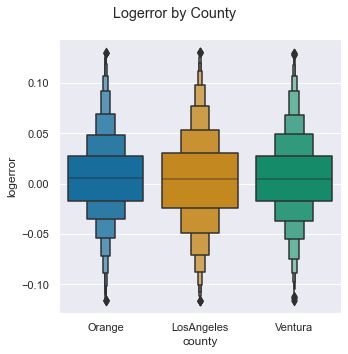

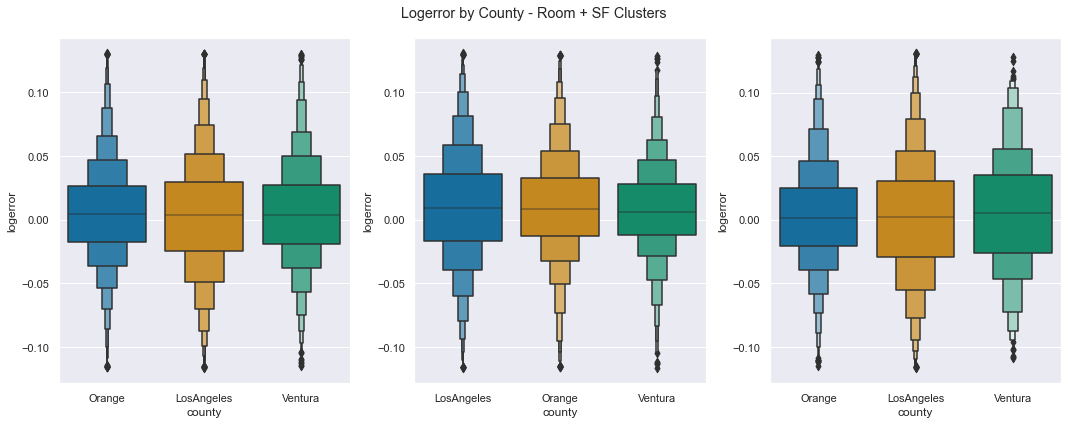

In [21]:
display(Markdown('### Is Logerror correlated with geography?'))
#Do Visualizations
g=sns.catplot(data=tr_eda,x='county',y='logerror',kind='boxen');
g.fig.suptitle('Logerror by County'); plt.tight_layout();
#repeat viz for room+sf cluster
fig = plt.figure(figsize=(15,6))
for cnt, cl in enumerate(tr.cluster_roomSF.unique()):
    plt.subplot(1,3,cnt+1)
    sns.boxenplot(data=tr[tr.cluster_roomSF == cl],x='county',y='logerror');
fig.suptitle('Logerror by County - Room + SF Clusters'); plt.tight_layout();

<div class="alert alert-success"><b>Notes:</b> The above graphs show no relationships between logerror and county.  For this, I did not break it out using the geographic clusters as that wouldn't be as valuable.  Instead, the second set of plots show the room+SF clusters, each of which shows nothing helpful when looking at logerror by county.</div>

### Is Logerror correlated with transaction month?

### Is Logerror correlated with transaction month?

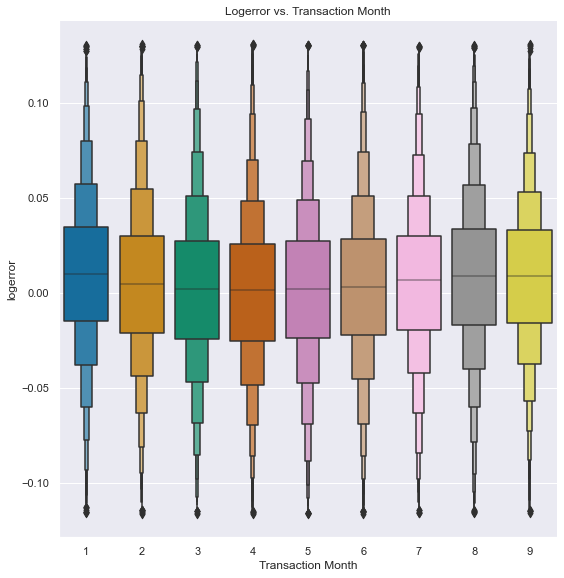

In [22]:
display(Markdown('### Is Logerror correlated with transaction month?'))
#Do Visualizations
sns.catplot(data=tr_eda,x='trans_month',y='logerror',kind='boxen',size=8); 
plt.title('Logerror vs. Transaction Month'); plt.xlabel('Transaction Month');

### Is Logerror correlated with transaction month?

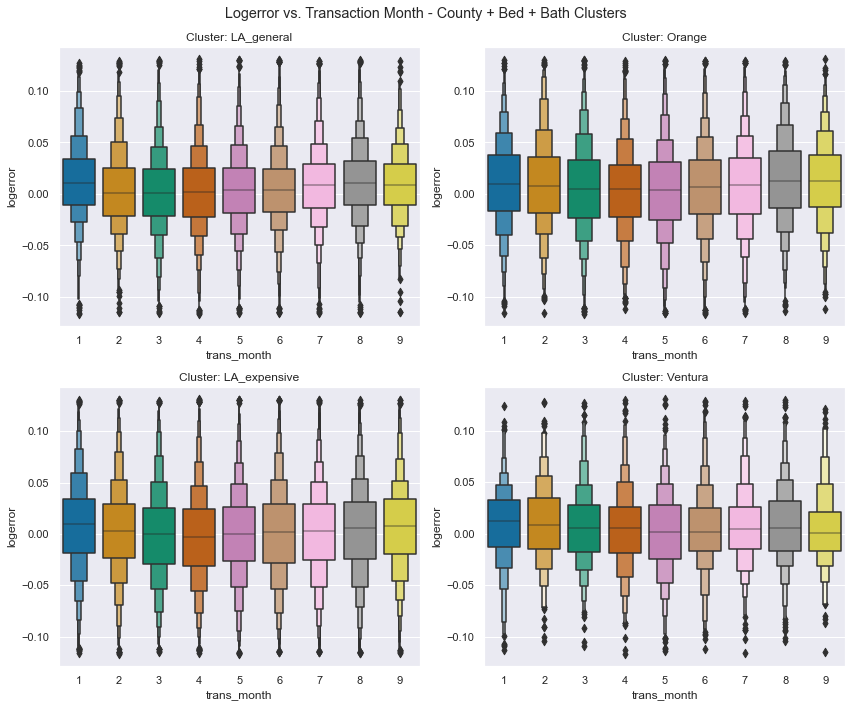

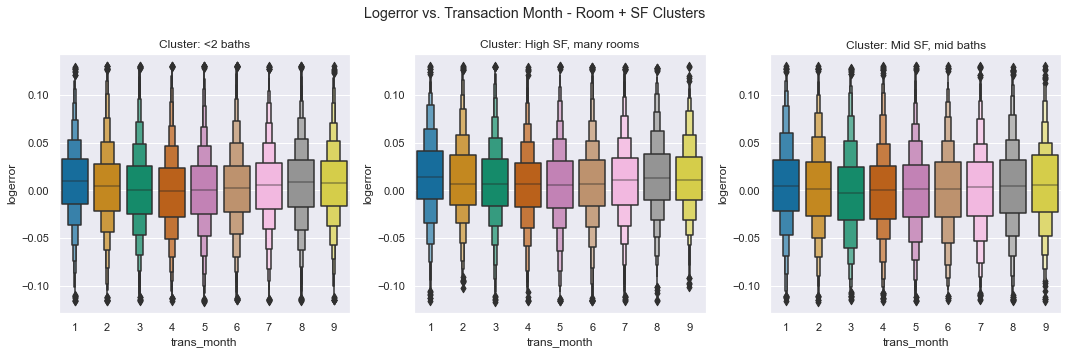

In [23]:
display(Markdown('### Is Logerror correlated with transaction month?'))
#Do Visualizations
#repeat viz for simp cluster
fig = plt.figure(figsize=(12,10))
for cnt, cl in enumerate(tr.cluster_simp.unique()):
    plt.subplot(2,2,cnt+1)
    sns.boxenplot(data=tr[tr.cluster_simp == cl],x='trans_month',y='logerror');
    plt.title(f'Cluster: {cl}');
fig.suptitle('Logerror vs. Transaction Month - County + Bed + Bath Clusters'); plt.tight_layout();
#repeat viz for room+sf cluster
fig = plt.figure(figsize=(15,5))
for cnt, cl in enumerate(tr.cluster_roomSF.unique()):
    plt.subplot(1,3,cnt+1)
    sns.boxenplot(data=tr[tr.cluster_roomSF == cl],x='trans_month',y='logerror');
    plt.title(f'Cluster: {cl}');
fig.suptitle('Logerror vs. Transaction Month - Room + SF Clusters'); plt.tight_layout();



##### Run a t-test on transaction month and logerror

In [24]:
#for each month, compare that month to whole sample
for m in tr.trans_month.unique():
    null_h = f'The mean log error for month {m} is the same as that for the rest of the months'
    samp = tr[tr.trans_month == m] #pull out that month's data
    restofpop = tr[tr.trans_month != m]
    #run levene test for equal variance (p > .05, equal var can be set)
    tl, pl = stats.levene(samp.value,restofpop.value)
    #Run two tailed t test
    t, p = stats.ttest_ind(samp.value,restofpop.value,equal_var = (pl > .05))
    #Pretty print the results
    utils.stats_result(p,null_h,t=t)    


H₀: The mean log error for month 9 is the same as that for the rest of the months
We failed to reject the null hypothesis, p = 0.4871088536246775 | α = 0.05
  t: -0.694920907757718

H₀: The mean log error for month 8 is the same as that for the rest of the months
We failed to reject the null hypothesis, p = 0.9061836152958125 | α = 0.05
  t: 0.11785439205350316

H₀: The mean log error for month 7 is the same as that for the rest of the months
We reject the null hypothesis, p = 0.0020423947233419587 | α = 0.05
  t: 3.0841972632322516

H₀: The mean log error for month 1 is the same as that for the rest of the months
We reject the null hypothesis, p = 0.001900332999284743 | α = 0.05
  t: -3.10726443071824

H₀: The mean log error for month 4 is the same as that for the rest of the months
We failed to reject the null hypothesis, p = 0.11239162659327424 | α = 0.05
  t: -1.587569036019563

H₀: The mean log error for month 3 is the same as that for the rest of the months
We failed to reject t

<div class="alert alert-success"><b>Notes:</b> There does seem to be a small correlation between logerror and transaction month.  This does not appear to be any more notable when broken out by clusters.  Doing a ttest we find that months 1, 2, 6 and 7 had notably statistically significant different mean errors.</div>

### Exploration Summary:

> Logerror did not appear to have any clear primary drivers.  Home value and geography did not appear to be correlated with logerror.  Transaction month looked the most promising, with a t-test indicating that **January, February, June and July** have statistically significant means than the whole sample.  Of the clusters, the geographic set seemed to show the most variance with logerror. For modeling, I will use those same inputs of bed, sf and county - and add in transaction month.


***
## Modeling <a class="anchor" id="modeling" />
***
    
**Model Evaluation:** The models will be evaluated using RMSE.

**Models Performed:**
- Input Features: ['bed', 'sf', 'Orange','Ventura','trans_month']
- Model Types:
  - Linear Regression
  - Lasso Lars - alpha of 1 and 5
  - GLM - power 0

In [25]:
#split the subset
#all contains zip, X_tr contains all but zip, y_tr is target
mod_cols = ['bed', 'sf', 'Orange','Ventura','trans_month']
X_tr_mod = X_tr_scaled[mod_cols]
X_te_mod = X_te_scaled[mod_cols]
X_val_mod = X_val_scaled[mod_cols]
#target variables
y_tr = tr.logerror
y_te = te.logerror
y_val = val.logerror

#create results dataframes
tr_res = pd.DataFrame(y_tr)
tr_res.rename(columns={'logerror':'actual'},inplace=True)
val_res = pd.DataFrame(y_val)
val_res.rename(columns={'logerror':'actual'},inplace=True)

#Create Baseline - mean performed better than median - see modeling.ipynb for more details
tr_res['baseline'] = tr.logerror.mean()
val_res['baseline'] = tr.logerror.mean()

In [26]:
#initialize model dictionary and performance
model_dict ={}
mod_perf = pd.DataFrame()

#BASELINE
mod_perf.loc['baseline','rmse'] = utils.rmse(tr_res.actual,tr_res.baseline)

#LINEAR REGRESSION
model_name = 'lr'
#create and store model
model = LinearRegression(normalize=True).fit(X_tr_mod,y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mod)
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = utils.rmse(tr_res.actual,tr_res[model_name])


#LASSO LARS
model_name = 'll_a1'
#create and store model
model = LassoLars(alpha=1).fit(X_tr_mod,y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mod)
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = utils.rmse(tr_res.actual,tr_res[model_name])

#REPEAT for alpha = 5
model_name = 'll_a5'
#create and store model
model = LassoLars(alpha=5).fit(X_tr_mod,y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mod)
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = utils.rmse(tr_res.actual,tr_res[model_name])


#GENERALIZED LINEAR MODEL -pow1 k6 and 15
model_name = 'glm_pow0_a1'
#create and store model
model = TweedieRegressor(power=0,alpha=1).fit(X_tr_mod,y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mod)
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = utils.rmse(tr_res.actual,tr_res[model_name])


In [27]:
mod_perf

,rmse
baseline,0.043888
lr,0.043738
ll_a1,0.043888
ll_a5,0.043888
glm_pow0_a1,0.043876


##### Run models over validate

In [28]:
#models to run over validate
combined_perf = pd.DataFrame()
tr_res2 = pd.DataFrame()
#create new model performance dataframe
mod_perf_comp = pd.DataFrame()
for model_name in mod_perf.index[1:]:
    #grab model & kbest from dictionary:
    model = model_dict[model_name]['model']
    #generate prediction on tr & val dataset - adds new column
    tr_res2[model_name] = model.predict(X_tr_mod)
    val_res[model_name] = model.predict(X_val_mod)
    #gather model performance on tr & val
    combined_perf.loc['rmse',model_name] = utils.rmse(tr_res.actual,tr_res2[model_name])
    combined_perf.loc['rmse_val',model_name] = utils.rmse(val_res.actual,val_res[model_name])
    #determine improvement
    combined_perf.loc['rmse_diff',model_name] = combined_perf.loc['rmse_val',model_name] - combined_perf.loc['rmse',model_name]


In [29]:
combined_perf

,lr,ll_a1,ll_a5,glm_pow0_a1
rmse,0.043738,0.043888,0.043888,0.043876
rmse_val,0.043394,0.043526,0.043526,0.043518
rmse_diff,-0.000344,-0.000362,-0.000362,-0.000358


##### Run Linear regression on Test subset

In [30]:
model = model_dict['lr']['model']

#now see how it performs on test
te_pred = model.predict(X_te_mod)

print(f'Test RMSE: {utils.rmse(y_te,te_pred)}')

Test RMSE: 0.0432681765654428


### Modeling Summary:
The models barely outperformed the baseline on the train subset, with linear regression performing the best.  All models did slighly better on the validate set, however linear regression still performed the best.  This model was ran against the test subset and it performed consistently - with an RMSE of .04327.


***
## Conclusion <a class="anchor" id="ConclusionC88" />
***

**Goal Recap:** Identify trends in Zestimate errors and create a model for predicting when the zestimate will be accurate.

**Key Findings:**
> - There were no clear primary drivers for logerror.
> - The greatest trend was found to be between transaction month and logerror
> - While the linear regression model outperformed baseline, it was not in a significant way 

**Recommendations & Next Steps:**
> - Consider creating models for each of the clusters, with transaction date as a feature.
> - Determine acceptable errors and use it to explore the properties outside of this range.

